In [2]:
import os
import argparse
import networkx as nx
import math        
import numpy as np
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random, seed
import time

def get_rval(x):
    tmp = randint(0,99)
    if tmp%2:
        return randint(0,x-1)
    else:
        return randint(x+1,9)

def get_rval2(x):
    x1 = get_rval(x)
    x2 = get_rval(x)
    while abs(x1-x2)==1:
        x1 = get_rval(x)
        x2 = get_rval(x)
    return x1, x2

def get_random_occ_grid():
    row1 = randint(1,8)
    row2 = randint(1,8)
    while(row2 == row1 and row2 == row1 - 1 and row2 == row1 + 1):
        row2 = randint(1,8)
    col = randint(2,7)

    rc1, rc2 = get_rval2(col)
    cr1_1, cr1_2 = get_rval2(row1)
    cr2_1, cr2_2 = get_rval2(row2)

    occ_grid = np.ones((10,10))
    
    for i in range(10):
        if not (i==cr1_1 or i==cr1_2):
            occ_grid[row1,i] = 0

        if not (i==rc1 or i==rc2):
            occ_grid[i,col] = 0
            
        if not (i==cr2_1 or i==cr2_2):
            occ_grid[row2,i] = 0
            
            
    return occ_grid, row1, col



# Generating "DOF" definition of Landmark

In [3]:
total_data = 0
for num_data in range(total_data):
    occ_g, row1, col = get_random_occ_grid()
    data = occ_g.reshape(100)
    #fig1 = plt.figure(figsize=(10,6), dpi=80)
    #ax1 = fig1.add_subplot(111, aspect = 'equal')
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    num_landmark = 1000
    num_neighbor = 200
    radius_landmark = 0.7
    #landmark = np.zeros((num_landmark, 2))
    #graph = nx.Graph()
    cnt = 0
    for i in range(num_landmark):
        x = np.random.uniform(0, 10)
        y = np.random.uniform(0, 10)
        if occ_g[int(x)][int(y)] == 0:
            continue

        ratio = 0.0
        minus = 0.0
        for j in range(num_neighbor):
            r = np.random.uniform(0, radius_landmark)
            theta = np.random.uniform(0, 2*np.pi)
            x_ = x + r * np.cos(theta)
            y_ = y + r * np.sin(theta)
            if x_ >= 10 or x_ <= 0 or y_ >= 10 or y_ <= 0:
                minus += 1
                continue
            if occ_g[int(x_)][int(y_)] == 1:
                ratio += 1
        ratio = ratio / (num_neighbor - minus)
        #graph.add_node(i, coordinate = np.array([x, y]), rate = ratio, mean = 0, var = 0)
        if ratio <= 0.9:
            #print(ratio)
            data = np.append(data,x)
            data = np.append(data,y)
            #plt.scatter(x/10, y/10, color = 'blue', s = 10)
    '''
    for i in range(10):
            for j in range(10):
                if(occ_g[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/10.0, j/10.0),   # (x,y)
                    0.1,          # width
                    0.1,          # height
                    alpha=0.6
                    ))
    plt.show()
    '''
    print(num_data, data.shape)
    np.save('/home/zhizuo/lego/dataset/landmark_{}'.format(str(num_data)),data)

In [4]:
import torch.nn as nn
import torch.nn.functional as F


# =======================
# CVAE (MLP version)
# =======================
class CVAE_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(102, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(102, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace = True),
            nn.Linear(512, 2),
            nn.ReLU(inplace = True)
        )
        self.fc1 = nn.Linear(512, 2)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x, c):
        inputs = torch.cat((x, c), 1)
        outputs = self.encoder(inputs)
        z_mu = self.fc1(outputs)
        z_logvar = self.fc2(outputs)
        eps = torch.randn(size = z_mu.shape)
        if torch.cuda.is_available():
            eps = eps.cuda()
        tmp = torch.exp(z_logvar / 2)*eps
        if torch.cuda.is_available():
            tmp = tmp.cuda()
        z = z_mu + tmp
        
        inputs_1 = torch.cat((z,c), 1)
        
        outputs_1 = self.decoder(inputs_1)
        return z_mu, z_logvar, outputs_1

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# =======================
# CVAE (CNN version)
# =======================
class CVAE_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        def c_block(in_filters, out_filters, kernel_size = 3, stride = 1, padding = 1, bn=False):
            if bn:
                block = [nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding), 
                         nn.BatchNorm2d(out_filters),
                         nn.LeakyReLU(0.2, inplace = True), 
                         nn.Dropout2d(0.25)]
            else:
                block = [nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding), 
                         nn.LeakyReLU(0.2, inplace = True), 
                         nn.Dropout2d(0.25)]
            return block
        
        #self.deconv_en = nn.ConvTranspose2d(2,1,10, stride = 1, padding=0)
        #self.decon_de = nn.ConvTranspose2d(2,1,10, stride = 1, padding = 0)
        
        # ====================
        # Encoder part
        # ====================
        self.deconv_en = nn.Sequential(
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
        )
        self.encoder = nn.Sequential(
            *c_block(7,   32, 3, 2, 1),
            *c_block(32,  64, 3, 1, 0),
            *c_block(64,  128, 3, 1, 0),
        )
        
        self.mu_mlp = nn.Linear(128, 2)
        self.logvar_mlp = nn.Linear(128, 2)
        
        # ====================
        # Decoder part
        # ====================
        self.deconv_de = nn.Sequential(
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners = True),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
            nn.ConvTranspose2d(6, 6, 3, 1, 0),
        )
        self.decoder = nn.Sequential(
            *c_block(7,   32, 3, 2, 1),
            *c_block(32,  64, 3, 1, 0),
            *c_block(64,  128, 3, 1, 0),
        )
        
        self.predict_mlp = nn.Linear(128, 2)
        
        
    def forward(self, x, c):
        # Encoder
        x = x.view(x.shape[0], 2, 1, -1)
        cat = c[:, 0:4]
        cat = cat.view(cat.shape[0], 4, 1, -1)
        x_en = torch.cat((x, cat), 1)
        c_en = c[:, 4:].view(c.shape[0], 1, 10, -1)
        deconv_x = self.deconv_en(x_en)
        input_en = torch.cat((deconv_x, c_en), 1)
        output_en = self.encoder(input_en)
        output_en = output_en.view(output_en.shape[0], 1, -1)
        z_mu = self.mu_mlp(output_en)
        z_logvar = self.logvar_mlp(output_en)

        
        # Latent space
        eps = torch.randn(size = z_mu.shape)
        if torch.cuda.is_available():
            eps = eps.cuda()
        tmp = torch.exp(z_logvar / 2)*eps
        if torch.cuda.is_available():
            tmp = tmp.cuda()
        z = z_mu + tmp
        z = z.view(z.shape[0], 2, 1, -1)
        # Decoder 
        z = torch.cat((z, cat), 1)
        z_deconv = self.deconv_de(z)
        input_decoder = torch.cat((z_deconv,c_en), 1)
        output_decoder = self.decoder(input_decoder)
        output_decoder = output_decoder.view(output_decoder.shape[0], 1, -1)
        predict = self.predict_mlp(output_decoder)
        predict = predict.view(predict.shape[0],-1)
        return z_mu, z_logvar, predict

    
def KL_loss(z_mu, z_logvar):
    return 2 * torch.sum(torch.exp(z_logvar) + 
                        z_mu**2 - 1. - z_logvar, dim=1).mean()
def Recon_loss(labels, predictions):
    loss = nn.MSELoss()
    return loss(labels, predictions)



In [6]:
import argparse
from torch import optim
import sys
sys.argv=['']
del sys
parser = argparse.ArgumentParser()
parser.add_argument("--max_epochs", type=int, default=4000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.9, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--eps", type=float, default=1e-8, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
#parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
#parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
#parser.add_argument("--channels", type=int, default=1, help="number of image channels")
#parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt = parser.parse_args()
print(opt)

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

landmark_data = []
total_data = 50
for i in range(total_data):
    data = np.load('/home/zhizuo/lego/dataset/landmark_{}.npy'.format(str(i)))
    length = data.shape[0]
    for j in range(int((length - 100)/2)) :
        tmp = np.concatenate((data[0:100], data[(100+j*2):(100+j*2+2)]))
        landmark_data.append(tmp)
        
landmark_data = np.array(landmark_data)
print(landmark_data.shape)
    
class LandmarkSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)
    



Namespace(b1=0.9, b2=0.999, batch_size=128, eps=1e-08, lr=0.0001, max_epochs=4000, n_cpu=8)


FileNotFoundError: [Errno 2] No such file or directory: '/home/zhizuo/lego/dataset/landmark_0.npy'

# Train for Lego Dataset

In [10]:
from torch.utils.data import Dataset, DataLoader
import networkx as nx
from process_it import process_it

# ==============================
# Lego shortest path dataset
# ==============================

class LegoSet(Dataset):
    def __init__(self, x, c, train):
        self.x = torch.FloatTensor(x)
        self.c = torch.FloatTensor(c)
        self.train = train
        
    def __getitem__(self, index):
        return self.x[index], self.c[index]
        
    def __len__(self):
        return len(self.x)

    
G = nx.read_graphml("graphs/dense_graph.graphml")
data_dir = "dataset"

directory = data_dir
print(directory)
data = np.array(process_it(G, directory))
print("shape of array: ", data.shape)
numEntries = data.shape[0]
dim = 2
dataElements = dim * 3 + 10 * 10
z_dim = 2
X_dim = dim
y_dim = dim
ratioTestTrain = 0.8
numTrain = int(numEntries * ratioTestTrain)
X_train = data[0:numTrain, 0:dim]
c_train = data[0:numTrain, dim:dataElements]

X_test = data[numTrain:numEntries, 0:dim]
c_test = data[numTrain:numEntries, dim:dataElements]
print(X_train.shape)
print(c_train.shape)
path = "/Users/zhangzhizuo/Desktop/UCSD/Su Lab/Code Lego/"
train_data = LegoSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)
test_data = LegoSet(x = X_test, c = c_test, train = False)
test_loader = DataLoader(test_data, batch_size = opt.batch_size, shuffle = False)

net = CVAE_CNN()
resume = None
#resume = "./Model/CVAE_CNN_2020_3_19_21.pkl"
if resume == None:
    net = CVAE_CNN()
else:
    net.load_state_dict(torch.load(resume))
    
if torch.cuda.is_available():
    net.cuda()
net.train()
optimizer = optim.Adam(net.parameters(), lr=opt.lr, 
                      betas=(opt.b1, opt.b2), eps=1e-08, weight_decay=0)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                            milestones = [50, 200, 500, 1000, 2000], gamma = 0.8)
epoch_loss = torch.zeros(opt.max_epochs)
epoch_recon_loss = torch.zeros(opt.max_epochs)
epoch_kl_loss = torch.zeros(opt.max_epochs)
for epoch in range(opt.max_epochs):
    print("Starting the {} epoch".format(epoch + 1))
    i = 0
    for x, c in train_loader:
        i += 1
        batch_elements = [randint(0, numTrain - 1)
                         for n in range(0, 256)]
        
        if(torch.cuda.is_available()):
            x = x.cuda()
            c = c.cuda()
        z_mu, z_logvar, predict = net(x, c)
        recon_loss = Recon_loss(x, predict)
        kl_loss = KL_loss(z_mu, z_logvar)
        alpha = 1.0
        beta = 1e-3
        loss = alpha * recon_loss + beta * kl_loss
        epoch_loss[epoch] += loss
        epoch_kl_loss[epoch] += kl_loss
        epoch_recon_loss[epoch] += recon_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    epoch_loss[epoch] = epoch_loss[epoch] / i
    epoch_kl_loss[epoch] = epoch_kl_loss[epoch] / i
    epoch_recon_loss[epoch] = epoch_recon_loss[epoch] / i
    print("Average loss of epoch {} : Loss {:.8f} Recon {:.8f} KL {:.8f}".
          format(epoch + 1, epoch_loss[epoch], epoch_recon_loss[epoch], epoch_kl_loss[epoch]))
    if (epoch + 1) % 2000 == 0:
        print("Saving the Model")
        localtime = time.localtime(time.time())
        torch.save(net.state_dict(), 
                  '/home/zhizuo/lego/models/CVAE_CNN_{}_{}_{}_{}.pkl'.
                  format(localtime[0], localtime[1], localtime[2], 
                         localtime[3], localtime[4]))
        print("Successfully save the model of {}".format(localtime))
net.eval()
epoch_loss = epoch_loss.data.numpy()
epoch_recon_loss = epoch_recon_loss.data.numpy()
epoch_kl_loss = epoch_kl_loss.data.numpy()


dataset
shape of array:  (21490, 106)
(17192, 2)
(17192, 104)
Starting the 1 epoch


KeyboardInterrupt: 

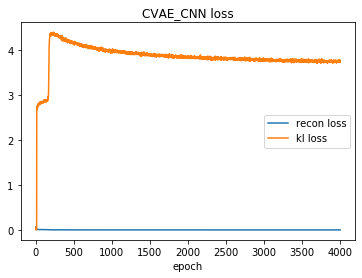

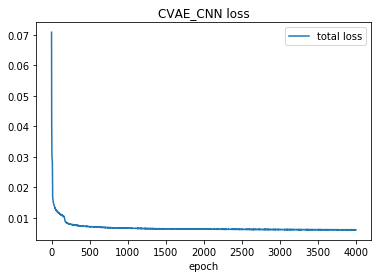

In [8]:
x = np.arange(0,opt.max_epochs)

plt.figure()
l2 = plt.plot(x, epoch_recon_loss, label='recon loss')
l3 = plt.plot(x, epoch_kl_loss, label='kl loss')
plt.title('CVAE_CNN loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.figure()
l1 = plt.plot(x, epoch_loss, label='total loss')
plt.title('CVAE_CNN loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Test for Lego Dataset, CVAE_CNN model

88
(100, 104)
0.38469786876863377 0.8633639878377255
0.23772521251863377 0.2881467953365824


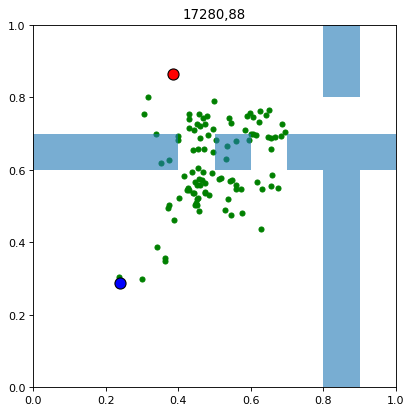

In [19]:
net = CVAE_CNN()
net.load_state_dict(torch.load(
     "/home/zhizuo/Landmark/models/CVAE_CNN_version1.pkl"))
data = np.array(process_it(G, directory))
num_viz = 100
# sample points of landmark
#vizIdx = randint(0, numTest - 1)
vizIdx = np.random.choice(range(4297))
vizIdx = 88
print(vizIdx)
c_sample_seed = data[numTrain + vizIdx, 2:]
c_sample_seed = data[vizIdx, 2:]
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
path = data[numTrain + vizIdx, 0:2]
goal = c_sample_seed[2:4]
c_sample = np.repeat([c_sample_seed], num_viz, axis = 0)
print(c_sample.shape)

net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))
c_sample_seed = torch.FloatTensor(c_sample_seed)
#print(y_viz)
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    z = z.view(1, 2, 1,-1)
    tmp = c_sample_seed[0:4]
    tmp = tmp.view(1, 4, 1, -1)
    z = torch.cat((z, tmp), 1)
    z_deconv = net.deconv_de(z)
    c = c_sample_seed[4:104].view(1, 1, 10, 10)
    y = net.decoder(torch.cat((z_deconv, c),1))
    y = y.view(1, 128)
    predict = net.predict_mlp(y)
    y_viz[i,:] = predict
    
y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(path[0], path[1], color = 'green', s = 20)
plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

print(init[0], init[1])
print(goal[0], goal[1])
plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()


88
(100, 104)
0.1 0.1
0.9 0.9


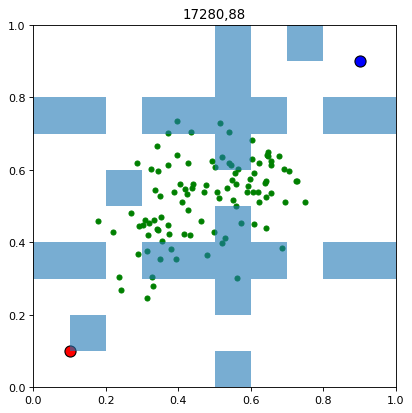

In [18]:
net = CVAE_CNN()
net.load_state_dict(torch.load(
     "/home/zhizuo/Landmark/models/CVAE_CNN_version1.pkl"))
data = np.array(process_it(G, directory))
num_viz = 100
# sample points of landmark
#vizIdx = randint(0, numTest - 1)
vizIdx = np.random.choice(range(4297))
vizIdx = 88
print(vizIdx)
c_sample_seed = data[numTrain + vizIdx, 2:]
c_sample_seed = np.array([0.1,0.1,0.9,0.9,1,1,1,0,1,1,1,0,1,1,\
                                          1,0,1,0,1,1,1,0,1,1,\
                                          1,1,1,1,1,0,1,1,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          0,1,0,0,0,1,0,0,0,0,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,1,1,1,1,1,1,0,\
                                          1,1,1,0,1,1,1,0,1,1,\
                                          1,1,1,0,1,1,1,0,1,1])
#c_sample_seed = data[vizIdx, 2:]
occ_g = c_sample_seed[4:].reshape(10,10)
init = c_sample_seed[:2]
path = data[numTrain + vizIdx, 0:2]
goal = c_sample_seed[2:4]
c_sample = np.repeat([c_sample_seed], num_viz, axis = 0)
print(c_sample.shape)

net = net.cpu()
y_viz = torch.FloatTensor(np.zeros((num_viz,2)))
c_sample_seed = torch.FloatTensor(c_sample_seed)
#print(y_viz)
for i in range(num_viz):
    z = torch.FloatTensor(np.random.randn(2))
    z = z.view(1, 2, 1,-1)
    tmp = c_sample_seed[0:4]
    tmp = tmp.view(1, 4, 1, -1)
    z = torch.cat((z, tmp), 1)
    z_deconv = net.deconv_de(z)
    c = c_sample_seed[4:104].view(1, 1, 10, 10)
    y = net.decoder(torch.cat((z_deconv, c),1))
    y = y.view(1, 128)
    predict = net.predict_mlp(y)
    y_viz[i,:] = predict
    
y_viz = y_viz.detach().numpy()
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect = 'equal')

plt.scatter(path[0], path[1], color = 'green', s = 20)
plt.scatter(y_viz[:,0], y_viz[:, 1], color = 'green', s = 20)
plt.title(str(numTrain+vizIdx) + "," + str(vizIdx))

print(init[0], init[1])
print(goal[0], goal[1])
plt.scatter(init[0], init[1], color = "red", s = 100, edgecolors = 'black')
plt.scatter(goal[0], goal[1], color = "blue", s = 100, edgecolors = 'black')

plt.xlim(0,1)
plt.ylim(0,1)

for i in range(10):
        for j in range(10):
            if(occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=0.6
                ))

plt.show()


# Train for DOF Landmark Dataset

In [ ]:
ratioTestTrain = 0.8
numEntries = landmark_data.shape[0]
numTrain = int(numEntries * ratioTestTrain)
X_train = landmark_data[0:numTrain,100:102]
c_train = landmark_data[0:numTrain,0:100]
X_test = landmark_data[numTrain:numEntries,100:102]
c_test = landmark_data[numTrain:numEntries,0:100]
train_data = LandmarkSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)
train_data = LandmarkSet(x = X_train, c = c_train, train = True)
train_loader = DataLoader(train_data, batch_size = opt.batch_size, shuffle = True)

net = CVAE_MLP()
#resume = "/home/zhizuo/lego/Model/lego2dCVAE_2020_3_4_0.pkl"
#resume == None
#if resume == None:
#    net = CVAE_CNN()
#else:
#    net.load_state_dict(torch.load(resume))
if(torch.cuda.is_available()):
    net.cuda()
net.train()

optimizer = optim.Adam(net.parameters(), lr = opt.lr, betas=(opt.b1,opt.b2), 
                       eps = opt.eps, weight_decay = 0)

for epoch in range(opt.n_epochs):
    print("Starting the {} epoch".format(epoch + 1))
    i = 0.0
    epoch_loss = 0.0
    for x, c in train_loader:
        i += 1
        if(torch.cuda.is_available()):
            x = x.cuda()
            c = c.cuda()
        z_mu, z_logvar, predict = net(x, c)
        recon_loss = Recon_loss(x, predict)
        kl_loss = KL_loss(z_mu, z_logvar)
        alpha = 1.0
        beta = 1e-4
        loss = alpha * recon_loss + beta * kl_loss
        epoch_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss = epoch_loss / i
    print("Average loss of epoch {} Recon = {:.8f}, KL = {:.8f}, Loss = {:.6f}".
         format(epoch + 1, i, recon_loss, kl_loss, loss))
    if(epoch + 1)%1000 == 0:
        print("Saving the Model")
        localtime = time.localtime(time.time())
        torch.save(net.state_dict(),
                  '/home/zhizuo/lego/Model/lego2d_CVAE_CNN_{}_{}_{}_{}.pkl'.
                  format(localtime[0], localtime[1], localtime[2], 
                         localtime[3], localtime[4]))
        print("Successfully save the model of 2D CVAE_CNN")
net.eval()

Starting the 1 epoch
Average loss of epoch 1 Recon = 682.00000000, KL = 0.38783458, Loss = 99.956390
Starting the 2 epoch
Average loss of epoch 2 Recon = 682.00000000, KL = 0.24451275, Loss = 97.403694
Starting the 3 epoch
Average loss of epoch 3 Recon = 682.00000000, KL = 0.21331200, Loss = 120.112122
Starting the 4 epoch
Average loss of epoch 4 Recon = 682.00000000, KL = 0.20904623, Loss = 122.604774
Starting the 5 epoch
Average loss of epoch 5 Recon = 682.00000000, KL = 0.18860741, Loss = 128.703003
Starting the 6 epoch
Average loss of epoch 6 Recon = 682.00000000, KL = 0.16114922, Loss = 120.740425
Starting the 7 epoch
Average loss of epoch 7 Recon = 682.00000000, KL = 0.15579909, Loss = 129.371063
Starting the 8 epoch
Average loss of epoch 8 Recon = 682.00000000, KL = 0.15855339, Loss = 127.962807
Starting the 9 epoch
Average loss of epoch 9 Recon = 682.00000000, KL = 0.13281532, Loss = 114.815910
Starting the 10 epoch
Average loss of epoch 10 Recon = 682.00000000, KL = 0.11393926

In [4]:
a = np.array([[4, 3],
              [3, 5]])
b = np.linalg.inv(a)
print(b)

[[ 0.45454545 -0.27272727]
 [-0.27272727  0.36363636]]
